In [43]:
from __future__ import print_function, division
from sklearn.datasets import fetch_20newsgroups

In [44]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score,log_loss
from sklearn.metrics import roc_curve
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from nltk.stem.snowball import SnowballStemmer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import save,load,save_plot,plot_confusion_matrix

# Part (a) : Data Visualization

In [3]:
categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'rec.autos',
              'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
train_data = {}
dic = {}
for i in range(len(categories)):
    temp_data = fetch_20newsgroups(subset='train', categories=categories[i:i+1], shuffle=True,
                                   random_state=42, remove=('headers','footers','quotes'))
    dic[i] = len(temp_data.data)
train_data = fetch_20newsgroups(subset='train', categories=categories, shuffle=True,
                                random_state=42, remove=('headers','footers','quotes'))
keys = []
vals = []

for key,val in dic.items():
    keys.append(key)
    vals.append(val)
    
fig = plt.figure(figsize=(15,15))
plotList = plt.bar(keys, vals, align='center', alpha=0.5)
color = ['r', 'g', 'b', 'grey', 'magenta', 'brown', 'pink', 'purple']
for i in range(len(keys)):
    plotList[i].set_color(color[i])
plt.xlabel('Categories',fontsize=15)
plt.xticks(keys, train_data.target_names, rotation=-45,fontsize=15)
plt.ylabel('Number of Records',fontsize=15)
plt.title('Histogram')
save_plot(fig,filename='histogram',directory='results')

# Part (b) : Calculating TF-IDF

In [45]:
categories = ['comp.graphics','comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware','comp.sys.mac.hardware',
             'rec.autos','rec.motorcycles','rec.sport.baseball','rec.sport.hockey']
twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True,
                                  random_state=42, remove=('headers','footers','quotes'))
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True,
                                 random_state=42, remove=('headers','footers','quotes'))
print("Length of training data ==>", len(twenty_train.data))
print("Length of testing data ==>", len(twenty_test.data))

Length of training data ==> 4732
Length of testing data ==> 3150


In [50]:
def initParams(tfidf_min_df):
    stemmer = SnowballStemmer('english')
    analyzer = CountVectorizer().build_analyzer()
    #Use token_pattern parameter with analyzer='word' if no stemming and want to remove words that are only numbers.
    vectorizer = CountVectorizer(stop_words='english', min_df=tfidf_min_df, max_df=0.8, analyzer=stemmedWords,
                                 strip_accents='ascii', token_pattern='\w*[a-zA-Z]')
    tfidf_transformer = TfidfTransformer()
    return [stemmer,analyzer,vectorizer,tfidf_transformer]

def getTfidf(vectorizer,tfidf_transformer,data,isTraining=True):
    if(isTraining):
        count_data = vectorizer.fit_transform(data)
        tfidf_data = tfidf_transformer.fit_transform(count_data)
    else:
        count_data = vectorizer.transform(data)
        tfidf_data = tfidf_transformer.transform(count_data)        
    return tfidf_data

def stemmedWords(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

stemmer,analyzer,vectorizer,tfidf_transformer = initParams(tfidf_min_df=2)

load_from_previous = False

if(load_from_previous):
    training_data = load('tfidf_training')
    testing_data = load('tfidf_testing')
else:
    training_data = getTfidf(vectorizer,tfidf_transformer,twenty_train.data)
    testing_data = getTfidf(vectorizer,tfidf_transformer,twenty_test.data,isTraining=False)
    save(training_data,'tfidf_training')
    save(testing_data,'tfidf_testing')

print('Shape of Training Data ==>', training_data.shape)
print('Shape of Testing Data ==>', testing_data.shape)



Shape of Training Data ==> (4732, 17020)
Shape of Testing Data ==> (3150, 17020)


In [52]:
print(training_data.nnz / float(training_data.shape[0]))
min_df='2'

70.9042688081


# Part (c) : Calculating TF-ICF

In [7]:
train_all = fetch_20newsgroups(subset='train', shuffle=True, random_state=42, remove=('headers','footers','quotes'))
categories = list(train_all.target_names)
category_train = {key:'\n '.join([train_all.data[i] for i in range(len(train_all.data)) 
                                  if train_all.target[i] == categories.index(key)]) for key in categories}
_,_,tfidf_vectorizer,tfidf_transformer = initParams(tfidf_min_df=1)
keys,values=[],[]
for k,v in category_train.items():
    keys.append(k)
    values.append(v)

tficf_data = getTfidf(tfidf_vectorizer,tfidf_transformer,values)
save(tficf_data,'tficf_data')


def topTfidfFeats(row, features, top_n=10):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def topFeatsInDoc(Xtr, features, row_id, top_n=10):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return topTfidfFeats(row, features, top_n)

def plotTopTfidfFeatures(df):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(14, 11), facecolor="w")
    x = np.arange(len(df))
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_frame_on(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=18)
    ax.set_title("label = " + str(df.label), fontsize=20)
    ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
    ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
    ax.set_yticks(x)
    ax.set_ylim([-1, x[-1]+1])
    ax.set_xticks(np.arange(0,1,0.1))
    ax.set_xlim([0,1])
    yticks = ax.set_yticklabels(df.feature, fontsize=18)
    save_plot(fig,filename=df.label,directory='results/imp_words')
    
for i in range(len(keys)):
    df = topFeatsInDoc(tficf_data, tfidf_vectorizer.get_feature_names(), i, top_n=10)
    df.label = keys[i]
    plotTopTfidfFeatures(df)

C:\Users\saboo.Varun\Anaconda2\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


# Part (d) : Feature Selection (Dimensionality Reduction)
Reduce the dimentionality of the corpus using the following two methods.
1. Latent Semantic Indexing (LSI)
2. Non-negative Matrix Factorization (NMF)
Compare the results for both methods.

In [53]:
load_from_previous = False
#LSI
def getLSI(data,lsi=None,isTrain=True):
    if(isTrain):
        lsi = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
        lsi_data = lsi.fit_transform(data)
    else:
        lsi_data = lsi.transform(data)
    return lsi,lsi_data

if(load_from_previous):
    model = load('lsi_model_'+min_df)
    lsi = model['model']
    lsi_train = model['train']
else:    
    lsi,lsi_train = getLSI(training_data)
    _,lsi_test = getLSI(testing_data,lsi,isTrain=False)
    save({'model':lsi,'train':lsi_train,'test':lsi_test},'lsi_model_'+min_df)
print('Shape of LSI Training Data ==>', lsi_train.shape)

#NMF
def getNMF(data,nmf=None,isTrain=True):
    if(isTrain):
        nmf = NMF(n_components=50, init='random', random_state=42)
        nmf_data = nmf.fit_transform(data)
    else:
        nmf_data = nmf.transform(data)
    return nmf,nmf_data

if(load_from_previous):
    model = load('nmf_model_'+min_df)
    nmf = model['model']
    nmf_train = model['train']
else:    
    nmf,nmf_train = getNMF(training_data)
    _,nmf_test = getNMF(testing_data,nmf,isTrain=False)
    save({'model':nmf,'train':nmf_train,'test':nmf_test},'nmf_model_'+min_df)
print('Shape of NMF Training Data ==>', nmf_train.shape)

Shape of LSI Training Data ==> (4732L, 50L)
Shape of NMF Training Data ==> (4732L, 50L)


# Part (e) : Binary Classification using SVM

---------------HARD SVM---------------
---------------LSI RESULTS---------------
Accuracy of model = 0.925079365079
Precision of model = 0.949685534591
Recall of model = 0.906362545018
             precision    recall  f1-score   support

          0       0.90      0.95      0.92      1484
          1       0.95      0.91      0.93      1666

avg / total       0.93      0.93      0.93      3150

Confusion matrix, without normalization
[[1404   80]
 [ 156 1510]]
(2L, 2L)


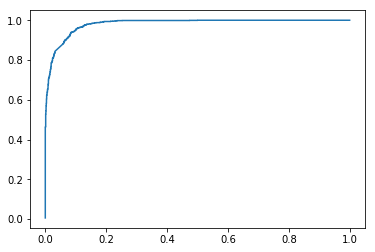

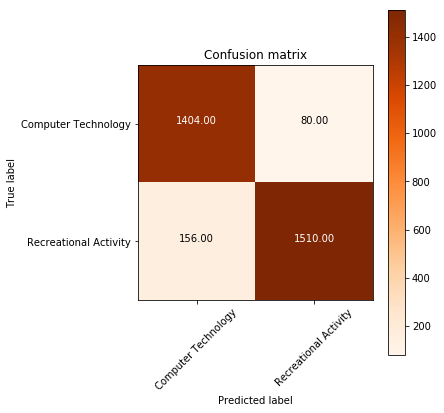

---------------NMF RESULTS---------------
Accuracy of model = 0.929206349206
Precision of model = 0.962893081761
Recall of model = 0.903244837758
             precision    recall  f1-score   support

          0       0.89      0.96      0.93      1455
          1       0.96      0.90      0.93      1695

avg / total       0.93      0.93      0.93      3150

Confusion matrix, without normalization
[[1396   59]
 [ 164 1531]]
(2L, 2L)


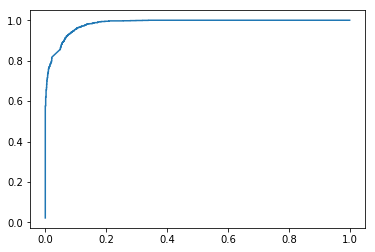

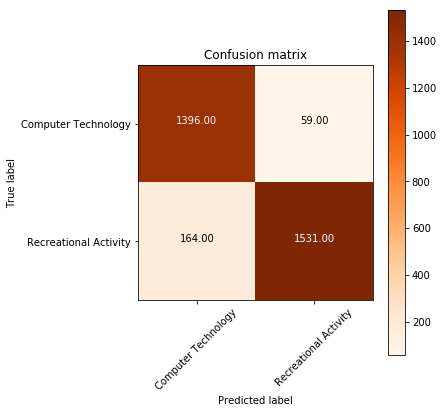

---------------SOFT SVM---------------
---------------LSI RESULTS---------------
Accuracy of model = 0.504761904762
Precision of model = 1.0
Recall of model = 0.504761904762
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.50      0.67      3150

avg / total       1.00      0.50      0.67      3150

Confusion matrix, without normalization
[[   0    0]
 [1560 1590]]
(2L, 2L)


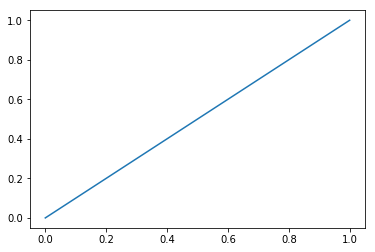

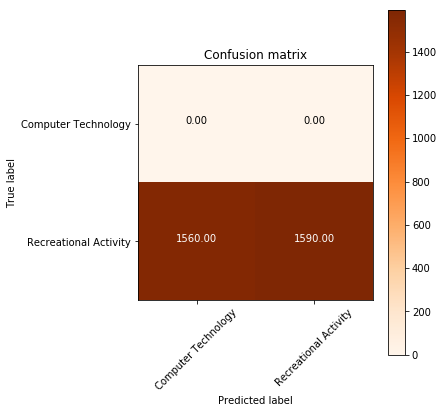

---------------NMF RESULTS---------------
Accuracy of model = 0.504761904762
Precision of model = 1.0
Recall of model = 0.504761904762
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.50      0.67      3150

avg / total       1.00      0.50      0.67      3150

Confusion matrix, without normalization
[[   0    0]
 [1560 1590]]
(2L, 2L)


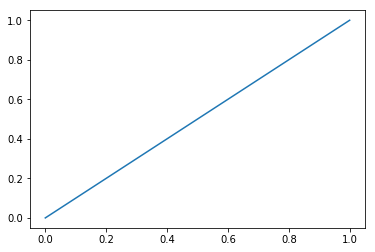

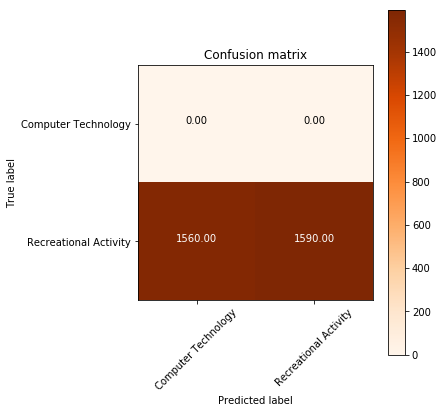

In [54]:
load_from_previous = True
train_target = np.array((map(lambda x : 0 if x<4 else 1,twenty_train.target)))
target_names = ['Computer Technology','Recreational Activity']
test_target = np.array((map(lambda x : 0 if x<4 else 1,twenty_test.target)))
#twenty_test.target_names = ['Computer Technology','Recreational Activity']

if(load_from_previous):
    lsi_test = load('lsi_model_'+min_df)['test']
    nmf_test = load('nmf_model_'+min_df)['test']
else:
    _,lsi_test = getLSI(testing_data,lsi,isTrain=False)
    _,nmf_test = getNMF(testing_data,nmf,isTrain=False)

def runSVM(lsi_train,nmf_train,train_target,lsi_test,nmf_test,test_target,C=1000):
    global min_df
    fig=plt.figure()
    print('---------------LSI RESULTS---------------')
    clf = svm.SVC(kernel='linear',C=C,random_state=42,probability=True)
    clf.fit(lsi_train,train_target)
    y_pred_lsi = clf.predict(lsi_test)
    print('Accuracy of model =',accuracy_score(y_pred_lsi,test_target))
    print('Precision of model =',precision_score(y_pred_lsi,test_target))
    print('Recall of model =',recall_score(y_pred_lsi,test_target))
    print(classification_report(y_pred_lsi,test_target))
    cfm = confusion_matrix(y_pred_lsi,test_target)
    y_pred_lsi = clf.predict_proba(lsi_test)
    y_prob = [x[1] for x in y_pred_lsi]
    fpr, tpr, thresholds = roc_curve(test_target, y_prob, drop_intermediate=False)
    plt.plot(fpr,tpr)
    save_plot(fig,filename='lsi_svm_'+min_df+'_'+str(C),directory='results/roc')
    save_plot(plot_confusion_matrix(cfm,target_names),
              filename='cfm_lsi_svm_'+min_df+'_'+str(C),directory='results/confusion_matrix')

    fig=plt.figure()
    print('---------------NMF RESULTS---------------')
    clf = svm.SVC(kernel='linear',C=C,random_state=42,probability=True)
    clf.fit(nmf_train,train_target)
    y_pred_nmf = clf.predict(nmf_test)
    print('Accuracy of model =',accuracy_score(y_pred_nmf,test_target))
    print('Precision of model =',precision_score(y_pred_nmf,test_target))
    print('Recall of model =',recall_score(y_pred_nmf,test_target))
    print(classification_report(y_pred_nmf,test_target))
    cfm = confusion_matrix(y_pred_nmf,test_target)
    y_pred_nmf = clf.predict_proba(nmf_test)
    y_prob = [x[1] for x in y_pred_nmf]
    fpr, tpr, thresholds = roc_curve(test_target, y_prob,drop_intermediate=False)
    plt.plot(fpr,tpr)
    save_plot(fig,filename='nmf_svm_'+min_df+'_'+str(C),directory='results/roc')
    save_plot(plot_confusion_matrix(cfm,target_names),
              filename='cfm_nmf_svm_'+min_df+'_'+str(C),directory='results/confusion_matrix')

print('---------------HARD SVM---------------')
runSVM(lsi_train,nmf_train,train_target,lsi_test,nmf_test,test_target,C=1000)

print('---------------SOFT SVM---------------')
runSVM(lsi_train,nmf_train,train_target,lsi_test,nmf_test,test_target,C=0.001)

# Part (f) : K-Fold Cross Validation

LSI
# Tuning hyper-parameters for accuracy - lsi
Best parameters set found on development set:
{'kernel': 'linear', 'C': 100}
Grid scores on development set:
0.505 (+/-0.000) for {'kernel': 'linear', 'C': 0.001}
0.506 (+/-0.001) for {'kernel': 'linear', 'C': 0.01}
0.905 (+/-0.020) for {'kernel': 'linear', 'C': 0.1}
0.927 (+/-0.019) for {'kernel': 'linear', 'C': 1}
0.932 (+/-0.017) for {'kernel': 'linear', 'C': 10}
0.934 (+/-0.019) for {'kernel': 'linear', 'C': 100}
0.934 (+/-0.018) for {'kernel': 'linear', 'C': 1000}
Detailed classification report:
Accuracy of model = 0.926349206349
Precision of model = 0.952830188679
Recall of model = 0.906100478469
             precision    recall  f1-score   support

          0       0.90      0.95      0.92      1478
          1       0.95      0.91      0.93      1672

avg / total       0.93      0.93      0.93      3150

Confusion matrix, without normalization
[[1403   75]
 [ 157 1515]]
(2L, 2L)


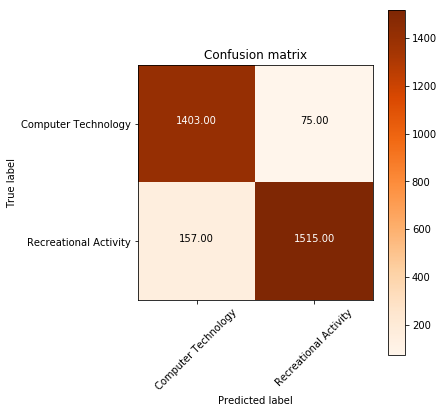

NMF
# Tuning hyper-parameters for accuracy - nmf
Best parameters set found on development set:
{'kernel': 'linear', 'C': 1000}
Grid scores on development set:
0.505 (+/-0.000) for {'kernel': 'linear', 'C': 0.001}
0.505 (+/-0.000) for {'kernel': 'linear', 'C': 0.01}
0.505 (+/-0.000) for {'kernel': 'linear', 'C': 0.1}
0.861 (+/-0.025) for {'kernel': 'linear', 'C': 1}
0.906 (+/-0.022) for {'kernel': 'linear', 'C': 10}
0.925 (+/-0.016) for {'kernel': 'linear', 'C': 100}
0.928 (+/-0.013) for {'kernel': 'linear', 'C': 1000}
Detailed classification report:
Accuracy of model = 0.929206349206
Precision of model = 0.962893081761
Recall of model = 0.903244837758
             precision    recall  f1-score   support

          0       0.89      0.96      0.93      1455
          1       0.96      0.90      0.93      1695

avg / total       0.93      0.93      0.93      3150

Confusion matrix, without normalization
[[1396   59]
 [ 164 1531]]
(2L, 2L)


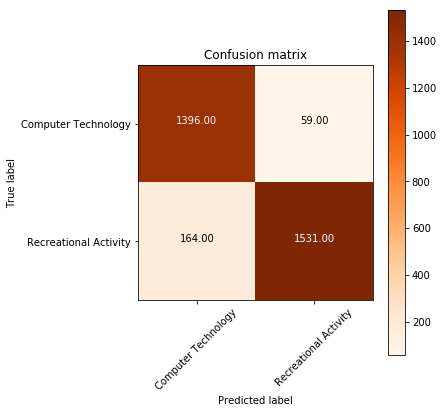

In [55]:
def kfold_cross_validation(train_data,train_target,test_data,test_target,typ):
    global min_df
    tuned_parameters = [{'kernel': ['linear'], 'C': [10**k for k in range(-3,4)]}]
    scores = ['accuracy']
    for score in scores:
        print("# Tuning hyper-parameters for {0} - {1}".format(score,typ))
        clf = GridSearchCV(svm.SVC(), tuned_parameters, cv=5,
                           scoring=score)
        clf.fit(train_data, train_target)

        print("Best parameters set found on development set:")
        print(clf.best_params_)
        print("Grid scores on development set:")
        for params, mean_score, scores in clf.grid_scores_:
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean_score, scores.std() * 2, params))
        print("Detailed classification report:")
        y_pred = clf.predict(test_data)
        print('Accuracy of model =',accuracy_score(y_pred,test_target))
        print('Precision of model =',precision_score(y_pred,test_target))
        print('Recall of model =',recall_score(y_pred,test_target))
        print(classification_report(y_pred,test_target))
        cfm = confusion_matrix(y_pred,test_target)
        save_plot(plot_confusion_matrix(cfm,target_names),
              filename='cfm_best_kfold_'+typ+'_'+min_df,directory='results/confusion_matrix')

print('LSI')
kfold_cross_validation(lsi_train,train_target,lsi_test,test_target,'lsi')
print('NMF')
kfold_cross_validation(nmf_train,train_target,nmf_test,test_target,'nmf')


# Part (g) : Naive Bayes Classifier

------------------Gaussian Naive Bayes (LSI)------------------
Accuracy of model = 0.733333333333
Precision of model = 0.965408805031
Recall of model = 0.661637931034
Confusion matrix, without normalization
[[ 775   55]
 [ 785 1535]]
(2L, 2L)


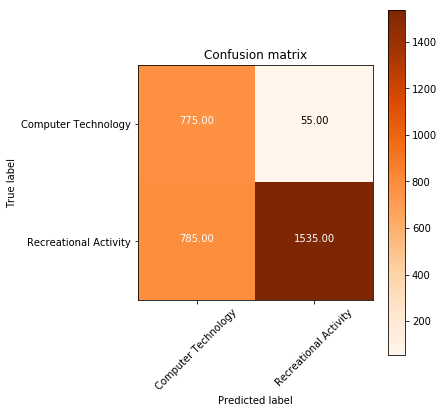

------------------Gaussian Naive Bayes (NMF)------------------
Accuracy of model = 0.901587301587
Precision of model = 0.968553459119
Recall of model = 0.855555555556
Confusion matrix, without normalization
[[1300   50]
 [ 260 1540]]
(2L, 2L)


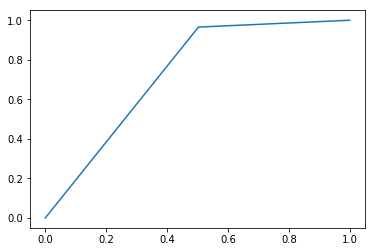

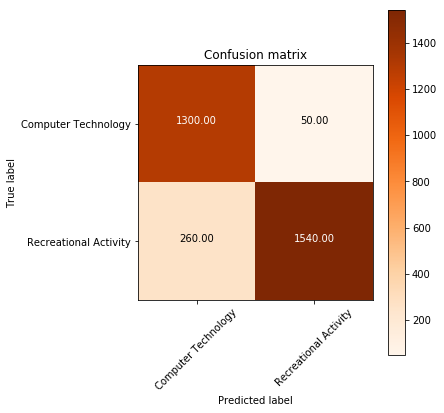

------------------Multinomial Naive Bayes (NMF)------------------
Accuracy of model = 0.901587301587
Precision of model = 0.968553459119
Recall of model = 0.855555555556
Confusion matrix, without normalization
[[1300   50]
 [ 260 1540]]
(2L, 2L)


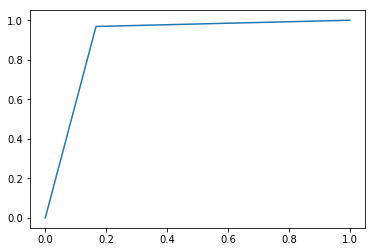

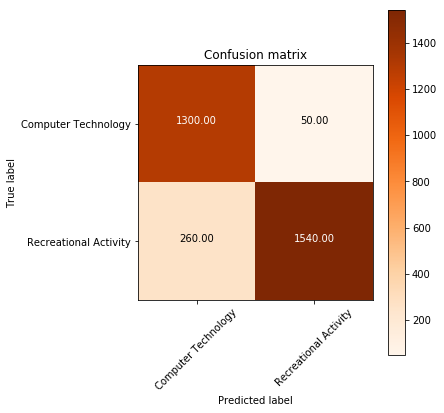

------------------Bernoulli Naive Bayes (NMF)------------------
Accuracy of model = 0.901587301587
Precision of model = 0.968553459119
Recall of model = 0.855555555556
Confusion matrix, without normalization
[[1300   50]
 [ 260 1540]]
(2L, 2L)


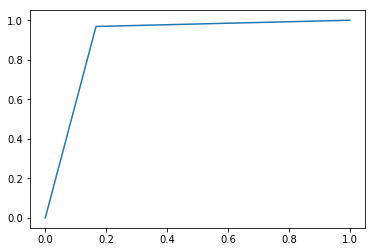

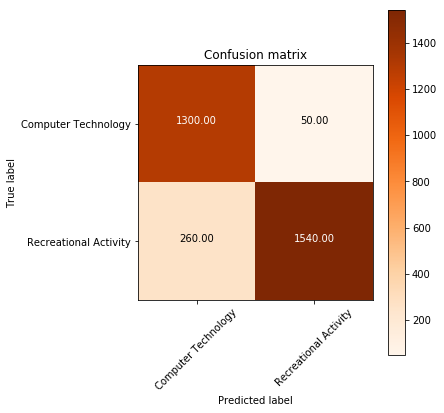

In [56]:
def plotROC(y_pred,test_target,filename):
    fig = plt.figure()
    fpr, tpr, thresholds = roc_curve(test_target, y_pred, drop_intermediate=False)
    plt.plot(fpr,tpr)
    save_plot(fig,filename,directory='results/roc')

print("------------------Gaussian Naive Bayes (LSI)------------------")
gnb = GaussianNB()
y_pred_lsi = gnb.fit(lsi_train, train_target).predict(lsi_test)
print('Accuracy of model =',accuracy_score(y_pred_lsi,test_target))
print('Precision of model =',precision_score(y_pred_lsi,test_target))
print('Recall of model =',recall_score(y_pred_lsi,test_target))
cfm = confusion_matrix(y_pred_lsi,test_target)
save_plot(plot_confusion_matrix(cfm,target_names),
              filename='cfm_gaussnb-lsi-'+min_df,directory='results/confusion_matrix')
plotROC(y_pred_lsi,test_target,'gaussnb-lsi-'+min_df)

print("------------------Gaussian Naive Bayes (NMF)------------------")
y_pred_nmf = gnb.fit(nmf_train, train_target).predict(nmf_test)
print('Accuracy of model =',accuracy_score(y_pred_nmf,test_target))
print('Precision of model =',precision_score(y_pred_nmf,test_target))
print('Recall of model =',recall_score(y_pred_nmf,test_target))
cfm = confusion_matrix(y_pred_nmf,test_target)
save_plot(plot_confusion_matrix(cfm,target_names),
              filename='cfm_gnb-nmf-'+min_df,directory='results/confusion_matrix')
plotROC(y_pred_nmf,test_target,'gnb-nmf-'+min_df)

print("------------------Multinomial Naive Bayes (NMF)------------------")
mnb = MultinomialNB()
y_pred = mnb.fit(nmf_train, train_target).predict(nmf_test)
print('Accuracy of model =',accuracy_score(y_pred_nmf,test_target))
print('Precision of model =',precision_score(y_pred_nmf,test_target))
print('Recall of model =',recall_score(y_pred_nmf,test_target))
cfm = confusion_matrix(y_pred_nmf,test_target)
save_plot(plot_confusion_matrix(cfm,target_names),
              filename='cfm_multinb-nmf-'+min_df,directory='results/confusion_matrix')
plotROC(y_pred_nmf,test_target,'multinb-'+min_df)

print("------------------Bernoulli Naive Bayes (NMF)------------------")
bnb = BernoulliNB()
y_pred = bnb.fit(nmf_train, train_target).predict(nmf_test)
print('Accuracy of model =',accuracy_score(y_pred_nmf,test_target))
print('Precision of model =',precision_score(y_pred_nmf,test_target))
print('Recall of model =',recall_score(y_pred_nmf,test_target))
cfm = confusion_matrix(y_pred_nmf,test_target)
save_plot(plot_confusion_matrix(cfm,target_names),
              filename='cfm_bernoullinb-'+min_df,directory='results/confusion_matrix')
plotROC(y_pred_nmf,test_target,'bernoullinb-'+min_df)

# Part (h) : Logistic Regression

------------------Logistic Regression (LSI)------------------
Accuracy of model = 0.91746031746
Precision of model = 0.953459119497
Recall of model = 0.89071680376
Loss of model = 2.85083842314
Confusion matrix, without normalization
[[1374   74]
 [ 186 1516]]
(2L, 2L)


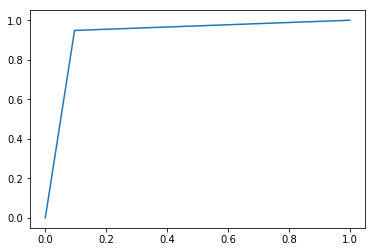

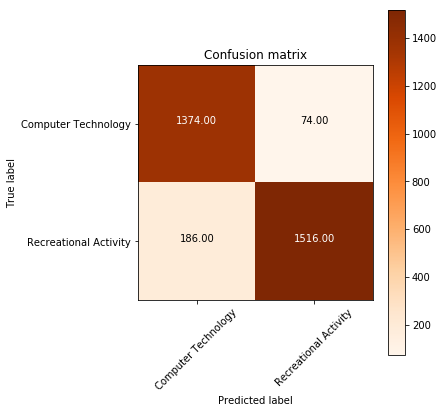

------------------Logistic Regression (NMF)------------------
Accuracy of model = 0.854920634921
Precision of model = 0.930817610063
Recall of model = 0.810071154899
Loss of model = 5.01089167244
Confusion matrix, without normalization
[[1213  110]
 [ 347 1480]]
(2L, 2L)


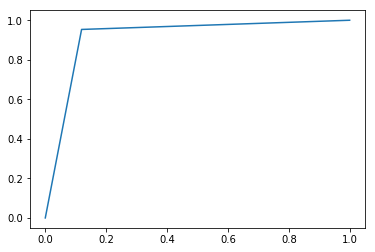

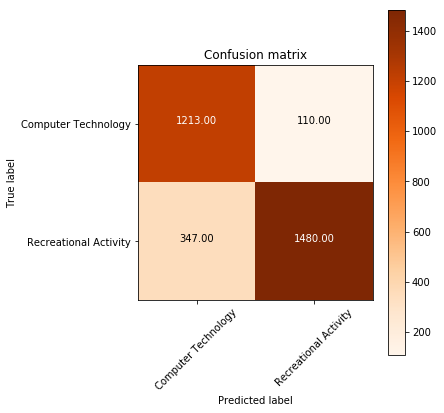

------------------Logistic Regression (LSI)------------------
Accuracy of model = 0.562222222222
Precision of model = 1.0
Recall of model = 0.535533849781
Loss of model = 15.1203087773
Confusion matrix, without normalization
[[ 181    0]
 [1379 1590]]
(2L, 2L)


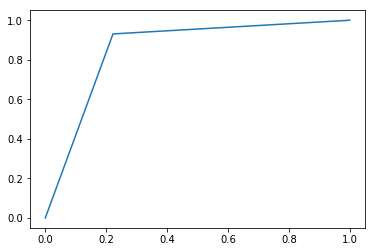

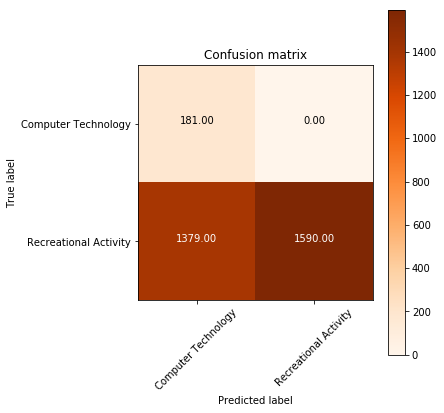

------------------Logistic Regression (NMF)------------------
Accuracy of model = 0.504761904762
Precision of model = 1.0
Recall of model = 0.504761904762


ValueError: y_true contains only one label (1). Please provide the true labels explicitly through the labels argument.

In [62]:
def logisticRegression(train,train_target,test,test_target,filename,penalty='l2',C=1.0):
    logres = LogisticRegression(C=C, penalty=penalty)
    y_pred = logres.fit(train,train_target).predict(test)
    print('Accuracy of model =',accuracy_score(y_pred,test_target))
    print('Precision of model =',precision_score(y_pred,test_target))
    print('Recall of model =',recall_score(y_pred,test_target))
    cfm = confusion_matrix(y_pred,test_target)
    save_plot(plot_confusion_matrix(cfm,target_names),
              filename='cfm_'+filename+'-'+penalty+str(C),directory='results/confusion_matrix')
    plotROC(y_pred,test_target,filename+'-'+penalty+str(C))

print("------------------Logistic Regression (LSI)------------------")
logisticRegression(lsi_train,train_target,lsi_test,test_target,'logres-lsi')

print("------------------Logistic Regression (NMF)------------------")
logisticRegression(nmf_train,train_target,nmf_test,test_target,'logres-nmf')

print("------------------Logistic Regression (LSI)------------------")
logisticRegression(lsi_train,train_target,lsi_test,test_target,'logres-lsi',C=.000000001)

print("------------------Logistic Regression (NMF)------------------")
logisticRegression(nmf_train,train_target,nmf_test,test_target,'logres-nmf',C=.000000001)


C = [10**k for k in range(-2,5)]
for c in C:
    print("------------------Logistic Regression (LSI C="+str(c)+")------------------")
    logisticRegression(lsi_train,train_target,lsi_test,test_target,'logres-lsi-'+str(c),C=c)


# Part (i) : Regularization for Logistic Regression
1. L2 regularization was done in Part (h).
2. In this part, we will do L1 regularization.

------------------Logistic Regression (LSI)------------------
Accuracy of model = 0.920317460317
Precision of model = 0.950943396226
Recall of model = 0.897329376855
Loss of model = 2.75215722023
Confusion matrix, without normalization
[[1387   78]
 [ 173 1512]]
(2L, 2L)


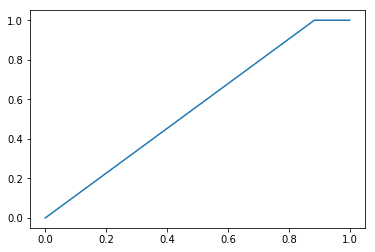

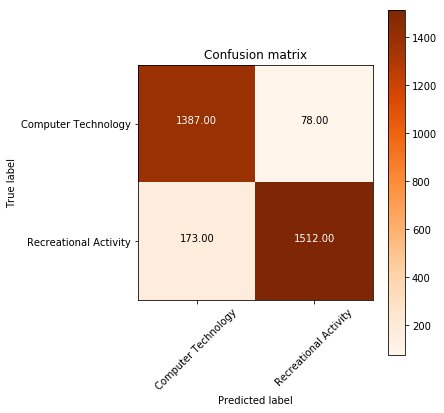

------------------Logistic Regression (NMF)------------------
Accuracy of model = 0.920952380952
Precision of model = 0.963522012579
Recall of model = 0.889146836912
Loss of model = 2.73022276158
Confusion matrix, without normalization
[[1369   58]
 [ 191 1532]]
(2L, 2L)


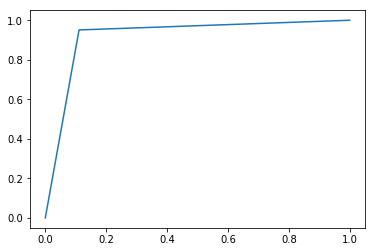

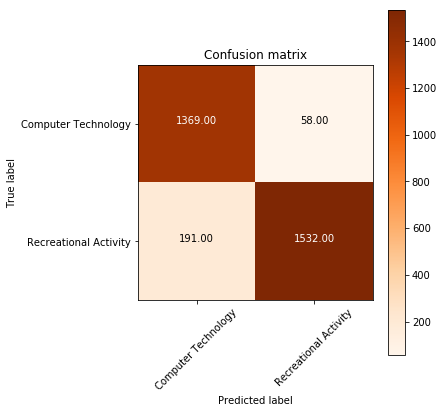

------------------Logistic Regression (TFIDF)------------------
Accuracy of model = 0.904126984127
Precision of model = 0.943396226415
Recall of model = 0.876168224299
Loss of model = 3.31135950318
Confusion matrix, without normalization
[[1348   90]
 [ 212 1500]]
(2L, 2L)


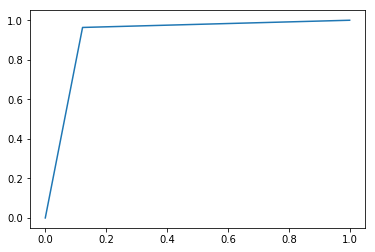

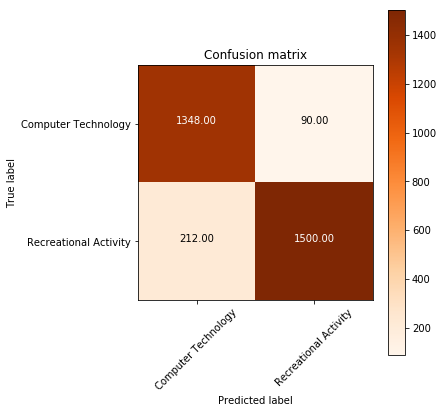

------------------Logistic Regression (LSI C=0.01)------------------
Accuracy of model = 0.851746031746
Precision of model = 0.806289308176
Recall of model = 0.889659958362
Loss of model = 5.12058884204
Confusion matrix, without normalization
[[1401  308]
 [ 159 1282]]
(2L, 2L)


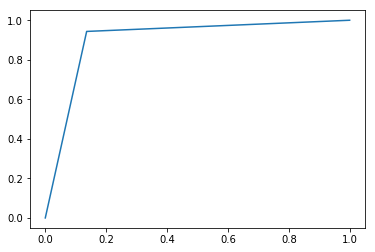

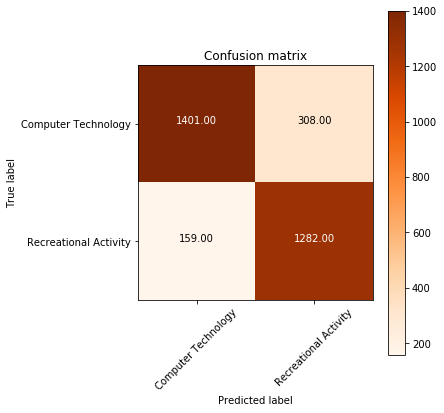

------------------Logistic Regression (LSI C=0.1)------------------
Accuracy of model = 0.874603174603
Precision of model = 0.907547169811
Recall of model = 0.853341218214
Loss of model = 4.33109022756
Confusion matrix, without normalization
[[1312  147]
 [ 248 1443]]
(2L, 2L)


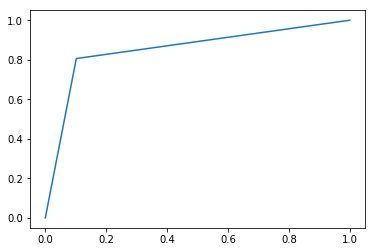

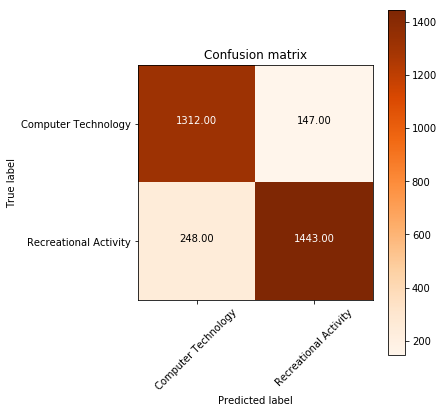

------------------Logistic Regression (LSI C=1)------------------
Accuracy of model = 0.920317460317
Precision of model = 0.950943396226
Recall of model = 0.897329376855
Loss of model = 2.75215722023
Confusion matrix, without normalization
[[1387   78]
 [ 173 1512]]
(2L, 2L)


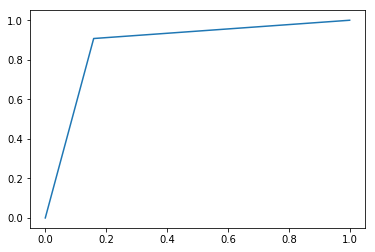

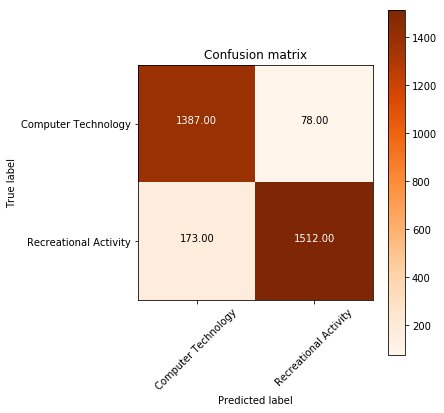

------------------Logistic Regression (LSI C=10)------------------
Accuracy of model = 0.926666666667
Precision of model = 0.949685534591
Recall of model = 0.909090909091
Loss of model = 2.53286390953
Confusion matrix, without normalization
[[1409   80]
 [ 151 1510]]
(2L, 2L)


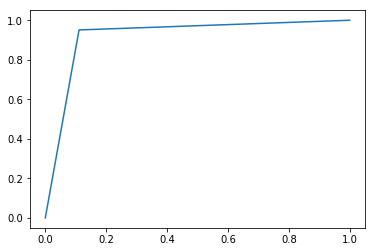

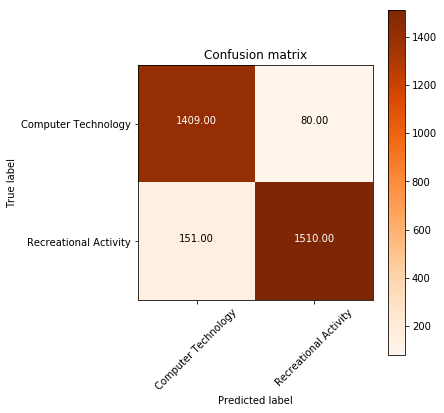

------------------Logistic Regression (LSI C=100)------------------
Accuracy of model = 0.926666666667
Precision of model = 0.949056603774
Recall of model = 0.909584086799
Loss of model = 2.53286416337
Confusion matrix, without normalization
[[1410   81]
 [ 150 1509]]
(2L, 2L)


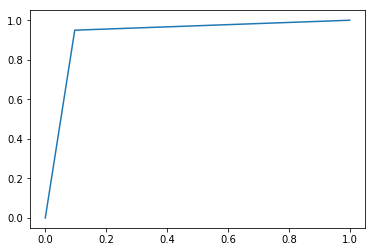

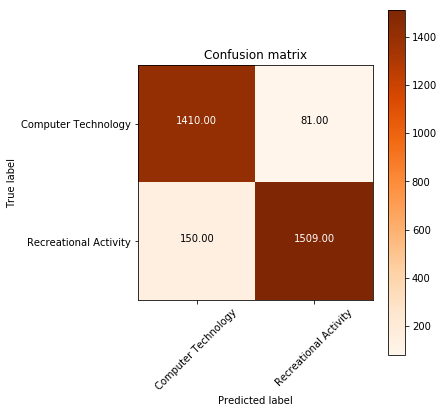

------------------Logistic Regression (LSI C=1000)------------------
Accuracy of model = 0.926031746032
Precision of model = 0.948427672956
Recall of model = 0.908981314045
Loss of model = 2.55479379905
Confusion matrix, without normalization
[[1409   82]
 [ 151 1508]]
(2L, 2L)


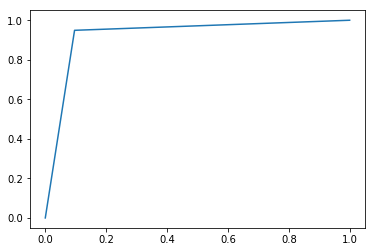

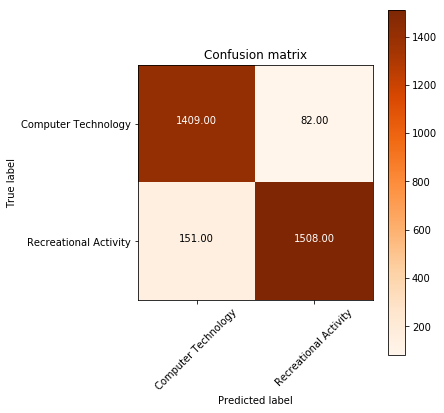

------------------Logistic Regression (LSI C=10000)------------------
Accuracy of model = 0.926031746032
Precision of model = 0.948427672956
Recall of model = 0.908981314045
Loss of model = 2.55479379905
Confusion matrix, without normalization
[[1409   82]
 [ 151 1508]]
(2L, 2L)


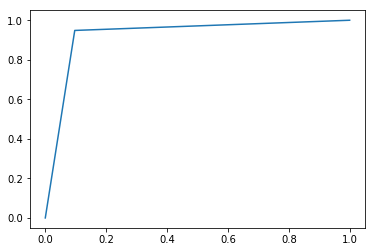

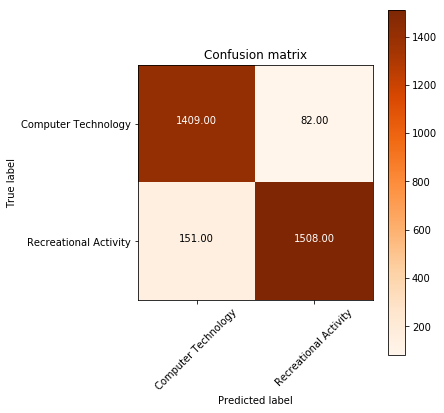

In [63]:
print("------------------Logistic Regression (LSI)------------------")
logisticRegression(lsi_train,train_target,lsi_test,test_target,'logres-lsi-'+min_df,penalty='l1')

print("------------------Logistic Regression (NMF)------------------")
logisticRegression(nmf_train,train_target,nmf_test,test_target,'logres-nmf-'+min_df,penalty='l1')

print("------------------Logistic Regression (TFIDF)------------------")
logisticRegression(training_data,train_target,testing_data,test_target,'logres-tfidf',penalty='l1')

C = [10**k for k in range(-2,5)]
for c in C:
    print("------------------Logistic Regression (LSI C="+str(c)+")------------------")
    logisticRegression(lsi_train,train_target,lsi_test,test_target,'logres-lsi-'+min_df+str(c),C=c,penalty='l1')

# Part (j) : Multiclass Classification

In [65]:
#Load data for multiclass and preprocess it.
categories = ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'misc.forsale','soc.religion.christian']
twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True,
                                  random_state=42, remove=('headers','footers','quotes'))
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True,
                                 random_state=42, remove=('headers','footers','quotes'))

stemmer,analyzer,vectorizer,tfidf_transformer = initParams(tfidf_min_df=2)
training_data = getTfidf(vectorizer,tfidf_transformer,twenty_train.data)
training_target = twenty_train.target
testing_data = getTfidf(vectorizer,tfidf_transformer,twenty_test.data,isTraining=False)
testing_target = twenty_test.target
nmf,nmf_train = getNMF(training_data)
_,nmf_test = getNMF(testing_data,nmf,isTrain=False)
lsi,lsi_train = getLSI(training_data)
_,lsi_test = getLSI(testing_data,lsi,isTrain=False)

In [66]:
print(training_data.shape)

(2352, 8222)


## Multiclass Naive Bayes 

------------------Bernoulli Naive Bayes------------------
Accuracy of model = 0.65750798722
Precision of model = [ 0.6377551   0.44675325  0.73333333  0.80653266]
Recall of model = [ 0.59241706  0.60777385  0.68095238  0.72954545]
             precision    recall  f1-score   support

          0       0.64      0.59      0.61       422
          1       0.45      0.61      0.51       283
          2       0.73      0.68      0.71       420
          3       0.81      0.73      0.77       440

avg / total       0.68      0.66      0.66      1565

Confusion matrix, without normalization
[[250 105  45  22]
 [ 61 172  24  26]
 [ 47  58 286  29]
 [ 34  50  35 321]]
(4L, 4L)


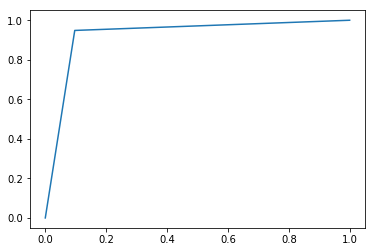

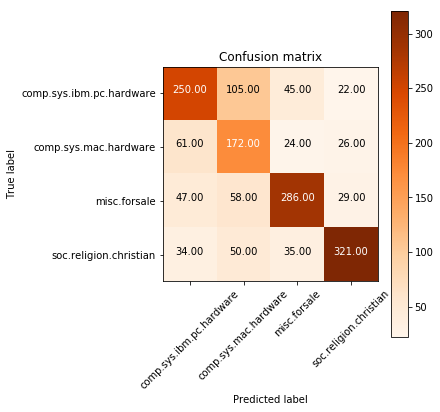

------------------Gaussian Naive Bayes------------------
Accuracy of model = 0.748881789137
Precision of model = [ 0.58673469  0.68571429  0.73846154  0.9798995 ]
Recall of model = [ 0.73015873  0.68571429  0.7890411   0.78      ]
Confusion matrix, without normalization
[[230  54  29   2]
 [ 93 264  27   1]
 [ 45  27 288   5]
 [ 24  40  46 390]]
(4L, 4L)


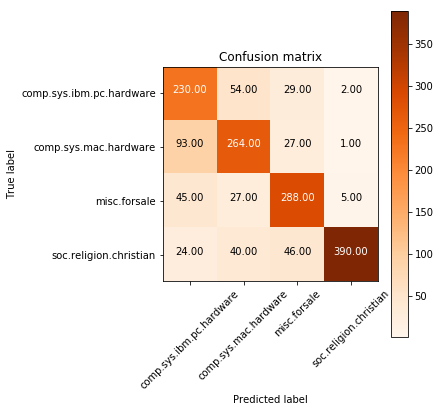

------------------Multinomial Naive Bayes------------------
Accuracy of model = 0.739297124601
Accuracy of model = 0.739297124601
Precision of model = [ 0.76530612  0.44155844  0.75384615  0.98743719]
Recall of model = [ 0.66371681  0.82524272  0.86725664  0.69190141]
Confusion matrix, without normalization
[[300 118  34   0]
 [ 28 170   8   0]
 [ 20  20 294   5]
 [ 44  77  54 393]]
(4L, 4L)


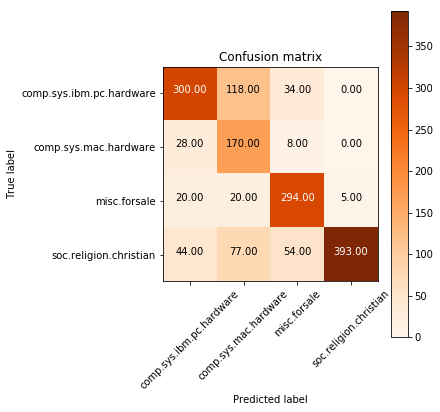

In [67]:
target_names = categories
print("------------------Bernoulli Naive Bayes------------------")
bnb = BernoulliNB()
y_pred = bnb.fit(nmf_train, training_target).predict(nmf_test)
print('Accuracy of model =',accuracy_score(y_pred,testing_target))
print('Precision of model =',precision_score(y_pred,testing_target, average=None))
print('Recall of model =',recall_score(y_pred,testing_target, average=None))
print(classification_report(y_pred,testing_target))
cfm = confusion_matrix(y_pred,testing_target)
save_plot(plot_confusion_matrix(cfm,target_names),
              filename='cfm_multiclass_bnb',directory='results/confusion_matrix')

print("------------------Gaussian Naive Bayes------------------")
bnb = GaussianNB()
y_pred = bnb.fit(nmf_train, training_target).predict(nmf_test)
print('Accuracy of model =',accuracy_score(y_pred,testing_target))
print('Precision of model =',precision_score(y_pred,testing_target, average=None))
print('Recall of model =',recall_score(y_pred,testing_target, average=None))
cfm = confusion_matrix(y_pred,testing_target)
save_plot(plot_confusion_matrix(cfm,target_names),
              filename='cfm_multiclass_gnb',directory='results/confusion_matrix')

print("------------------Multinomial Naive Bayes------------------")
bnb = MultinomialNB()
y_pred = bnb.fit(nmf_train, training_target).predict(nmf_test)
print('Accuracy of model =',accuracy_score(y_pred,testing_target))
print('Accuracy of model =',accuracy_score(y_pred,testing_target))
print('Precision of model =',precision_score(y_pred,testing_target, average=None))
print('Recall of model =',recall_score(y_pred,testing_target, average=None))
cfm = confusion_matrix(y_pred,testing_target)
save_plot(plot_confusion_matrix(cfm,target_names),
              filename='cfm_multiclass_mnb',directory='results/confusion_matrix')

## Multiclass SVM (One vs One)

Accuracy of model = 0.805111821086
Precision of model = [ 0.71428571  0.76623377  0.83589744  0.90201005]
Recall of model = [ 0.75471698  0.67505721  0.86243386  0.94722955]
Confusion matrix, without normalization
[[280  62  24   5]
 [ 88 295  33  21]
 [ 21  18 326  13]
 [  3  10   7 359]]
(4L, 4L)


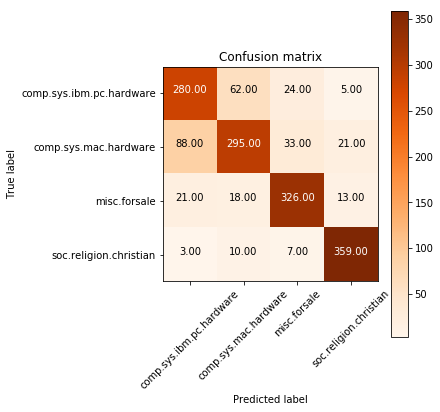

Accuracy of model = 0.800638977636
Precision of model = [ 0.71173469  0.75064935  0.82051282  0.91708543]
Recall of model = [ 0.71355499  0.68483412  0.86253369  0.95800525]
Confusion matrix, without normalization
[[279  70  36   6]
 [ 87 289  28  18]
 [ 22  20 320   9]
 [  4   6   6 365]]
(4L, 4L)


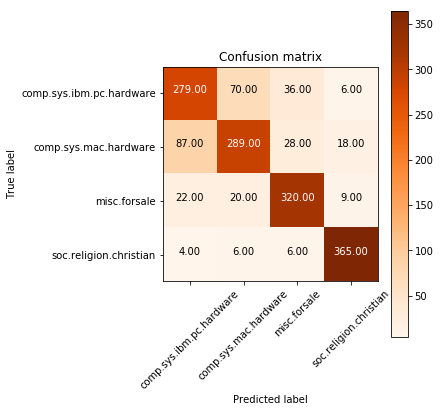

In [68]:
ovo_svc = OneVsOneClassifier(svm.SVC(kernel='linear',C=1000, random_state=42)).fit(lsi_train, training_target)
y_pred = ovo_svc.predict(lsi_test)
print('Accuracy of model =',accuracy_score(y_pred,testing_target))
print('Precision of model =',precision_score(y_pred,testing_target, average=None))
print('Recall of model =',recall_score(y_pred,testing_target, average=None))
cfm = confusion_matrix(y_pred,testing_target)
save_plot(plot_confusion_matrix(cfm,target_names),
              filename='cfm_multiclass_ovo_lsi',directory='results/confusion_matrix')

ovo_svc = OneVsOneClassifier(svm.SVC(kernel='linear',C=1000, random_state=42)).fit(nmf_train, training_target)
y_pred = ovo_svc.predict(nmf_test)
print('Accuracy of model =',accuracy_score(y_pred,testing_target))
print('Precision of model =',precision_score(y_pred,testing_target, average=None))
print('Recall of model =',recall_score(y_pred,testing_target, average=None))

cfm = confusion_matrix(y_pred,testing_target)
save_plot(plot_confusion_matrix(cfm,target_names),
              filename='cfm_multiclass_ovo_nmf',directory='results/confusion_matrix')

## Multiclass SVM (One vs Rest)

Accuracy of model = 0.814696485623
Precision of model = [ 0.70408163  0.74805195  0.84871795  0.95477387]
Recall of model = [ 0.75409836  0.74611399  0.86197917  0.88578089]
Confusion matrix, without normalization
[[276  58  27   5]
 [ 75 288  17   6]
 [ 28  18 331   7]
 [ 13  21  15 380]]
(4L, 4L)


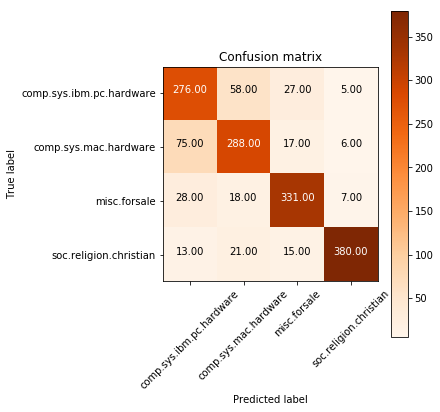

Accuracy of model = 0.803833865815
Precision of model = [ 0.7627551   0.69090909  0.83333333  0.92462312]
Recall of model = [ 0.67494357  0.76657061  0.85078534  0.93638677]
Confusion matrix, without normalization
[[299  86  40  18]
 [ 60 266  17   4]
 [ 26  23 325   8]
 [  7  10   8 368]]
(4L, 4L)


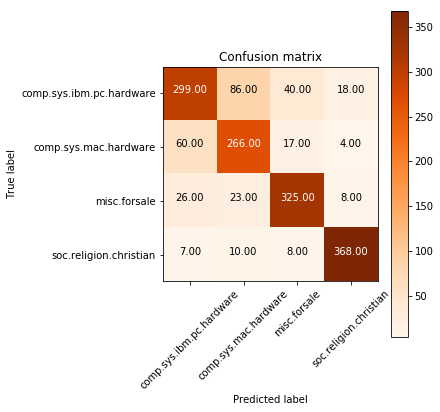

In [69]:
ovr_svc = OneVsRestClassifier(svm.SVC(kernel='linear',C=1000, random_state=42)).fit(lsi_train, training_target)
y_pred = ovr_svc.predict(lsi_test)
print('Accuracy of model =',accuracy_score(y_pred,testing_target))
print('Precision of model =',precision_score(y_pred,testing_target, average=None))
print('Recall of model =',recall_score(y_pred,testing_target, average=None))
cfm = confusion_matrix(y_pred,testing_target)
save_plot(plot_confusion_matrix(cfm,target_names),
              filename='cfm_multiclass_ovr_lsi',directory='results/confusion_matrix')

ovr_svc = OneVsRestClassifier(svm.SVC(kernel='linear',C=1000, random_state=42)).fit(nmf_train, training_target)
y_pred = ovr_svc.predict(nmf_test)
print('Accuracy of model =',accuracy_score(y_pred,testing_target))
print('Precision of model =',precision_score(y_pred,testing_target, average=None))
print('Recall of model =',recall_score(y_pred,testing_target, average=None))
cfm = confusion_matrix(y_pred,testing_target)
save_plot(plot_confusion_matrix(cfm,target_names),
              filename='cfm_multiclass_ovr_nmf',directory='results/confusion_matrix')